# 6M imagenet images /w neuronal responses

This demo shows a dataset that Konsti created in January, that contains the responses of 1244 neurons to ~6.5 million imagenet images. 
It was created by iterating 5 times over the imagenet training set (1.3M images) with different crops/scaling/rotations.

---

In [1]:
import deeplake
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

### log in to deeplake


In [2]:
!activeloop login -u username -p password

Successfully logged in to Activeloop.


## Load dataset

In [3]:
dataset = deeplake.load(('hub://sinzlab/imagenet_and_responses_5M'))

hub://sinzlab/imagenet_and_responses_5M loaded successfully.


/usr/local/lib/python3.8/dist-packages/deeplake/util/warnings.py:7: UserWarning: Checking out dataset in read only mode as another machine has locked this version for writing.
  warnings.warn(*args, **kwargs)


This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/imagenet_and_responses_5M


#### Dataset summary

In [4]:
dataset.summary()

Dataset(path='hub://sinzlab/imagenet_and_responses_5M', read_only=True, tensors=['images', 'responses'])

  tensor     htype          shape          dtype  compression
  -------   -------        -------        -------  ------- 
  images     image   (6405830, 100, 100)   uint8    jpeg   
 responses  generic    (6405830, 1244)    float16   None   


### get data individually

In [5]:
example_image = dataset.images[0]

In [6]:
example_image.numpy()

array([[ 68,  70,  72, ..., 163, 159, 153],
       [ 70,  71,  73, ..., 163, 156, 148],
       [ 70,  71,  72, ..., 178, 167, 155],
       ...,
       [208, 208, 211, ...,  88,  57,  36],
       [219, 221, 218, ..., 110,  72,  44],
       [229, 230, 220, ..., 125,  86,  57]], dtype=uint8)

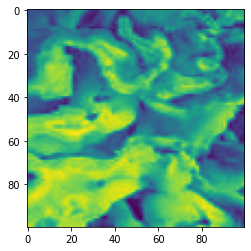

In [7]:
plt.imshow(example_image)

In [8]:
example_response = dataset.responses[0].numpy()

In [9]:
# notice that the dtype is float16
example_response

array([0.514 , 0.1864, 0.196 , ..., 0.4038, 0.1254, 0.645 ], dtype=float16)

## Build PyTorch DataLoaders from the cloud

In [10]:
tform = transforms.Compose([
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.4876], [0.2756,]), # images are grayscale, mean and std are taken from our actual monkey data
])

# note that the responses are stored as numpy.float16. To use them for model training for example, make sure to case them to the correct type
# this can be done as a transform while loading the data
tform_responses = transforms.Compose([lambda x: x.astype(np.float32)])



dataloader = dataset.pytorch(tensors=("responses","images"), 
                        num_workers=0, 
                        batch_size=256, 
                        transform={'images': tform,  'responses': tform_responses}, 
                        shuffle=False,
                        decode_method=dict(images="pil", responses="numpy"))

In [11]:
batch = next(iter(dataloader))

In [12]:
batch.keys()

odict_keys(['images', 'responses'])

In [13]:
batch["responses"]

tensor([[0.5142, 0.1864, 0.1960,  ..., 0.4038, 0.1254, 0.6450],
        [0.6294, 0.2173, 1.1348,  ..., 0.4094, 0.1393, 0.6528],
        [0.4563, 0.2229, 0.3027,  ..., 0.5728, 0.1223, 0.4077],
        ...,
        [0.7715, 0.9448, 0.4910,  ..., 0.3257, 0.1195, 0.4080],
        [0.6333, 0.1259, 0.1968,  ..., 0.2502, 0.1179, 0.6465],
        [0.5889, 0.2542, 0.4929,  ..., 0.4807, 0.1295, 0.8496]])

In [14]:
batch["responses"].shape

torch.Size([256, 1244])

In [15]:
batch["images"].shape

torch.Size([256, 1, 100, 100])

In [16]:
from tqdm import tqdm

In [18]:
# streaming from the cloud is not so fast. If the dataset is used multiple times, consider just copying it to the local disk (see demo notebooks)
for i, batch in tqdm(enumerate(dataloader)):
    if i == 100:
        break

# or: use faster dataloader below

100it [01:30,  1.11it/s]


---

# Enterprise Dataloader

Deeplake offers a different kind of dataloader with limited functionality, that is much faster. 

We can use it because we are on a free academic plan. Your deeplake user account has to be added to the deeplake sinzlab organization for it to work.

The dataloader is limited in scope, but can be used for our dataset with a bit of hacking:

In [19]:
tform = transforms.Compose([
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.4876], [0.2756,]), # images are grayscale, mean and std are taken from our actual monkey data
])

# the numpy array has to be read from pure bytes, that's why the more complex transforms
tform_responses = transforms.Compose([lambda x: np.frombuffer(x, dtype=np.float16).astype(np.float32)])



batch_size = 256
# create dataloader by chaining with transform function and batch size and returns batch of pytorch tensors
fast_dataloader = dataset.dataloader()\
    .transform({'images': tform, 'responses': tform_responses})\
    .batch(batch_size)\
    .shuffle(False)\
    .pytorch(decode_method=dict(images="pil", responses="tobytes"))

In [20]:
b = next(iter(fast_dataloader))

In [21]:
b["responses"].shape

torch.Size([256, 1244])

In [22]:
b["images"].shape

torch.Size([256, 1, 100, 100])

In [23]:
from tqdm import tqdm

In [24]:
# streaming from the cloud is not so fast. If the dataset is used multiple times, consider just copying it to the local disk (see demo notebooks)
for i, batch in tqdm(enumerate(fast_dataloader)):
    if i == 100:
        break

100it [00:16,  6.23it/s]


In [25]:
batch

IterableOrderedDict([('images',
                      tensor([[[[-0.7590, -0.3890, -0.4459,  ...,  0.9059,  0.9628,  0.9628],
                                [-0.8159, -0.6024, -0.1329,  ...,  0.9343,  1.1193,  1.0766],
                                [-1.0578, -0.9866, -0.0190,  ...,  0.7209,  0.9628,  0.9201],
                                ...,
                                [ 0.4790, -0.3036, -0.1756,  ...,  0.8063,  0.5928,  0.5786],
                                [ 0.4790, -0.1613, -0.0190,  ...,  0.7778,  0.5644,  0.5359],
                                [ 0.3225, -0.2609, -0.1756,  ...,  0.7920,  0.5928,  0.5786]]],
                      
                      
                              [[[-0.7020, -0.9155, -0.3036,  ...,  1.1904,  1.2047,  1.2189],
                                [-0.6309, -0.8870, -0.3890,  ...,  1.1478,  1.1335,  1.1335],
                                [-0.5171, -0.8301, -0.5313,  ...,  0.8205,  0.7778,  0.7493],
                                ...,
